In [1]:
%run common-imports.ipynb

#  Old Faithful Geyser

![Old Faithful Geyser of Yellowstone, Wyoming](https://upload.wikimedia.org/wikipedia/commons/e/ef/Bierstadt_Albert_Old_Faithful.jpg)

> (Old faithful geyser of the Yellowstone National Park, Wyoming, USA. This painting is by Albert Bierstadt; it is in the public domain and taken from Wikipedia).


This is a classic dataset, of the famous "Old Faithful Geyser". A part of its geothermal activities has been its periodic eruptions which have been consistently happening for decades, spaced between 40 minutes to 2 hours apart.

For the old faithful geyser, after an eruption has finished, the waiting time to the next eruption is related to the duration of this eruption that just finished. We will explore this, and build a regression model to predict the waiting time.


In [2]:
raw_data = pd.read_csv("../datasets/old-faithful-geyser.csv", sep='\t')
scaler = StandardScaler()
scaled = scaler.fit_transform(raw_data)
data = pd.DataFrame(data={'eruptions':scaled[:, 0], 'waiting': scaled[:,1]})
data.describe()

,eruptions,waiting
count,2.720000e+02,2.720000e+02
mean,5.053147e-16,4.398034e-16
std,1.001843e+00,1.001843e+00
min,-1.657009e+00,-2.055795e+00
25%,-1.163053e+00,-9.504124e-01
50%,4.496005e-01,3.760469e-01
75%,8.483203e-01,8.182000e-01
max,1.415130e+00,1.849891e+00


In [3]:
data.sample(5)

,eruptions,waiting
30,0.712927,0.154970
116,-1.027660,-1.539950
79,0.098499,0.891892
127,0.888478,0.818200
196,0.010723,1.186661


#### Descriptive statistics


In [4]:
data.describe(include="all").transpose()

,count,mean,std,min,25%,50%,75%,max
eruptions,272.0,5.053147e-16,1.001843,-1.657009,-1.163053,0.449601,0.84832,1.415130
waiting,272.0,4.398034e-16,1.001843,-2.055795,-0.950412,0.376047,0.81820,1.849891


#### Missing Values Analysis


In [5]:
data.isnull().sum()

eruptions    0
waiting      0
dtype: int64

#### Pandas Profiling



In [6]:
# Uncomment this to run it.
data.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Data Visualization

### Plotting using matplotlib

Let us first visualize a scatter plot of the data and look at the histogram of the features. Finally, let us pull of this together with a kernel density plot, into a single plot with subplots.

looking at the plots, it looks that a simple linear regression (OLS) may work well for this data. 

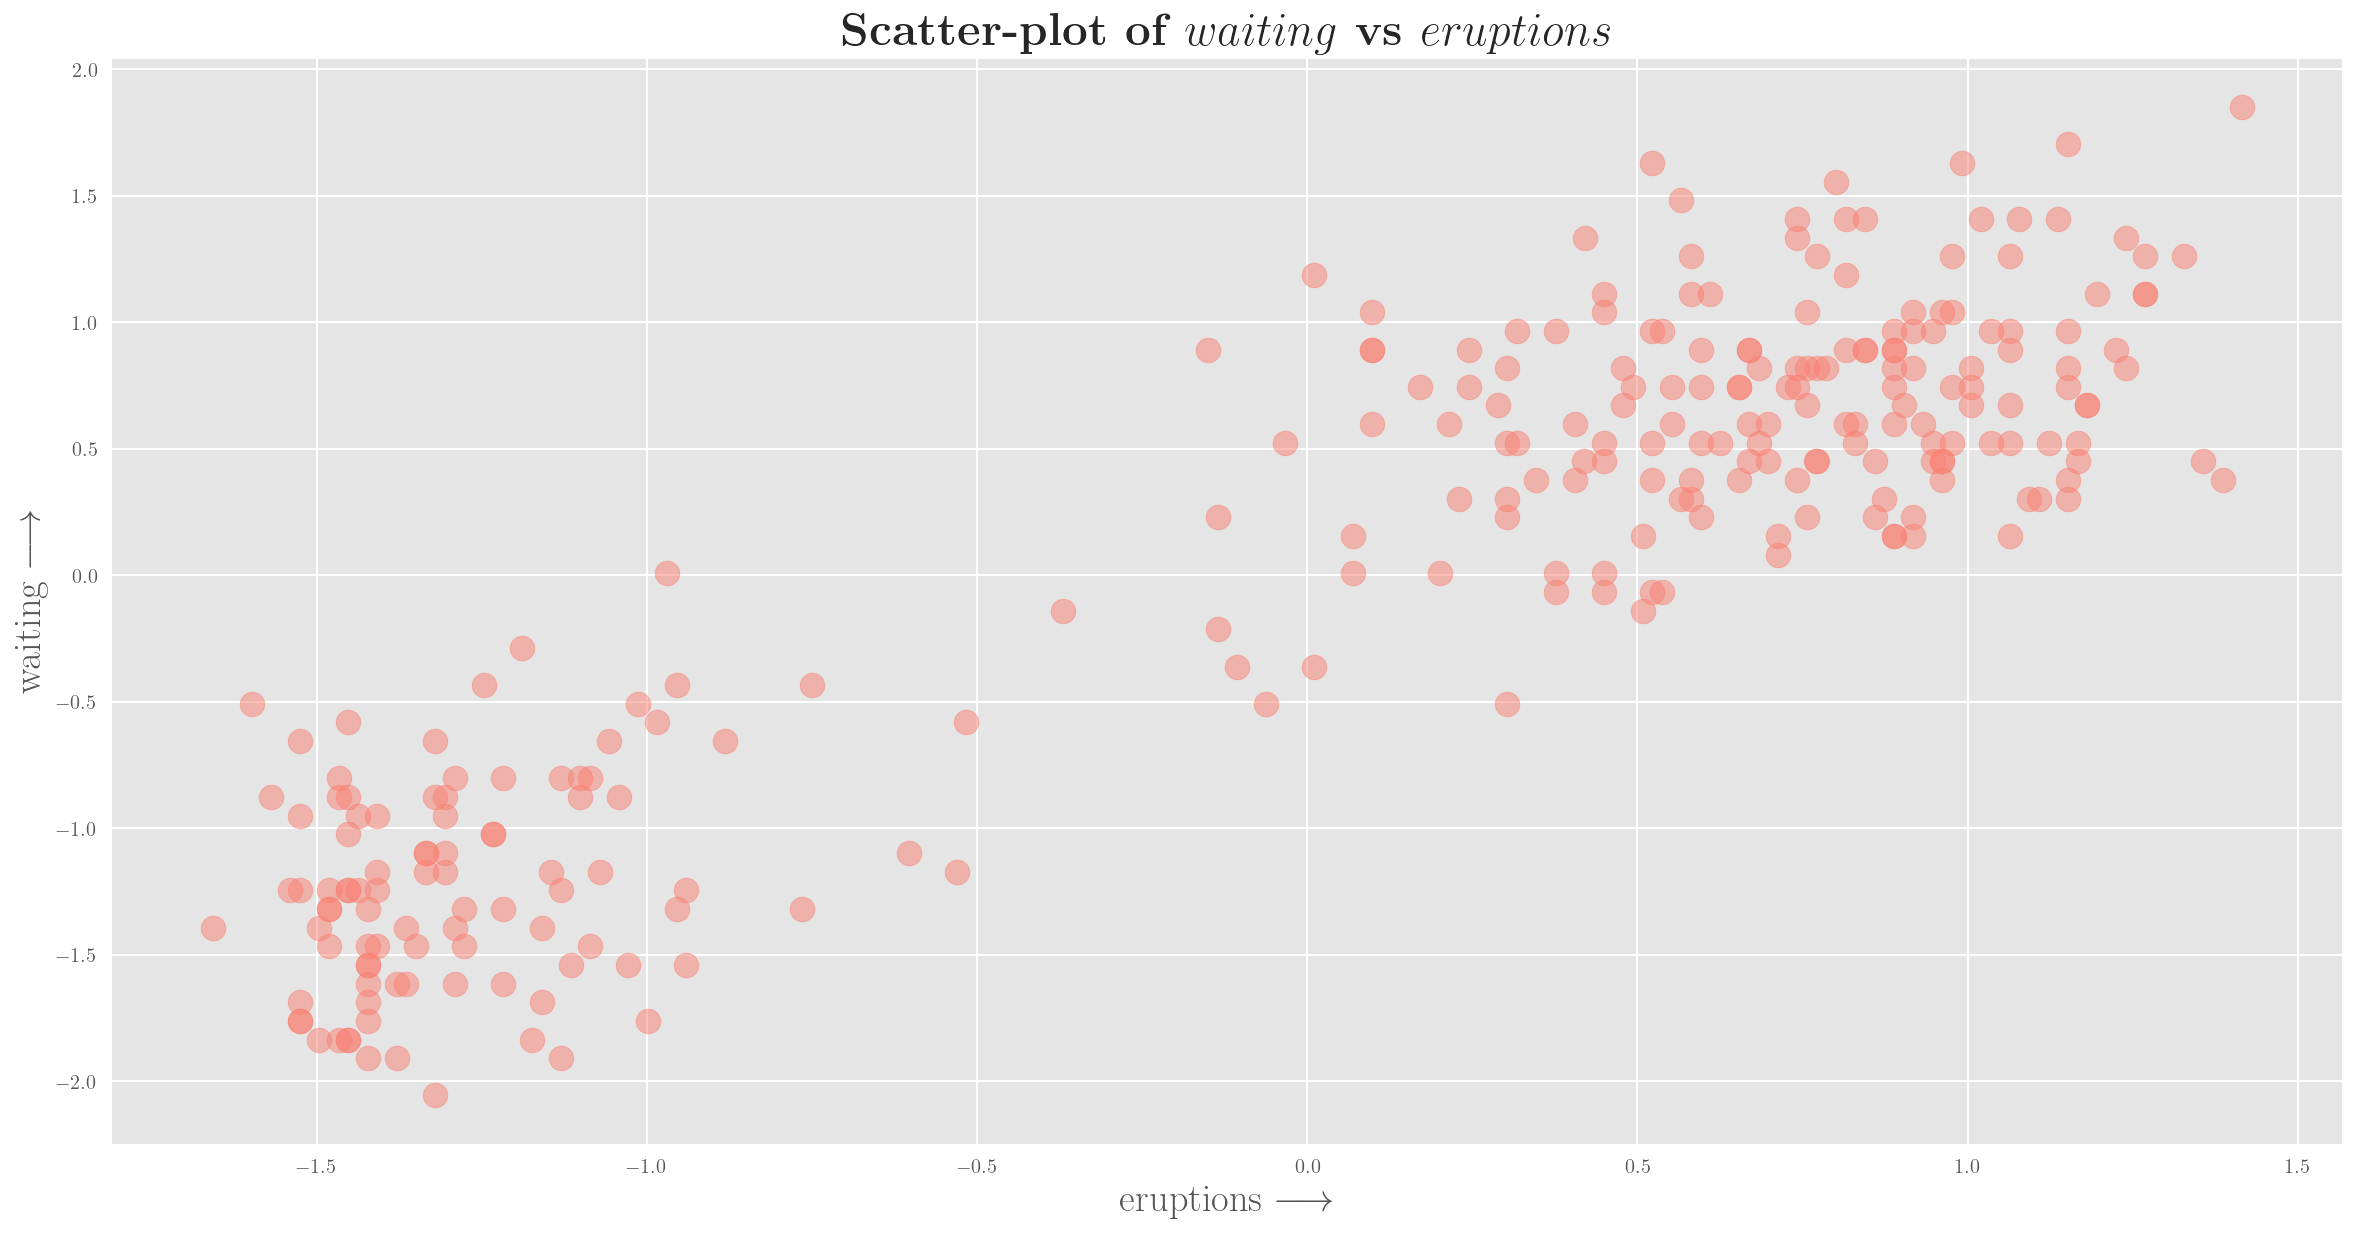

In [7]:
plt.scatter(data['eruptions'], data['waiting'], alpha=0.5, s=150, color='salmon')
plt.title(r'\textbf{Scatter-plot of $waiting$ vs $eruptions$}')
plt.xlabel(r'eruptions $\longrightarrow$');
plt.ylabel(r'waiting $\longrightarrow$');

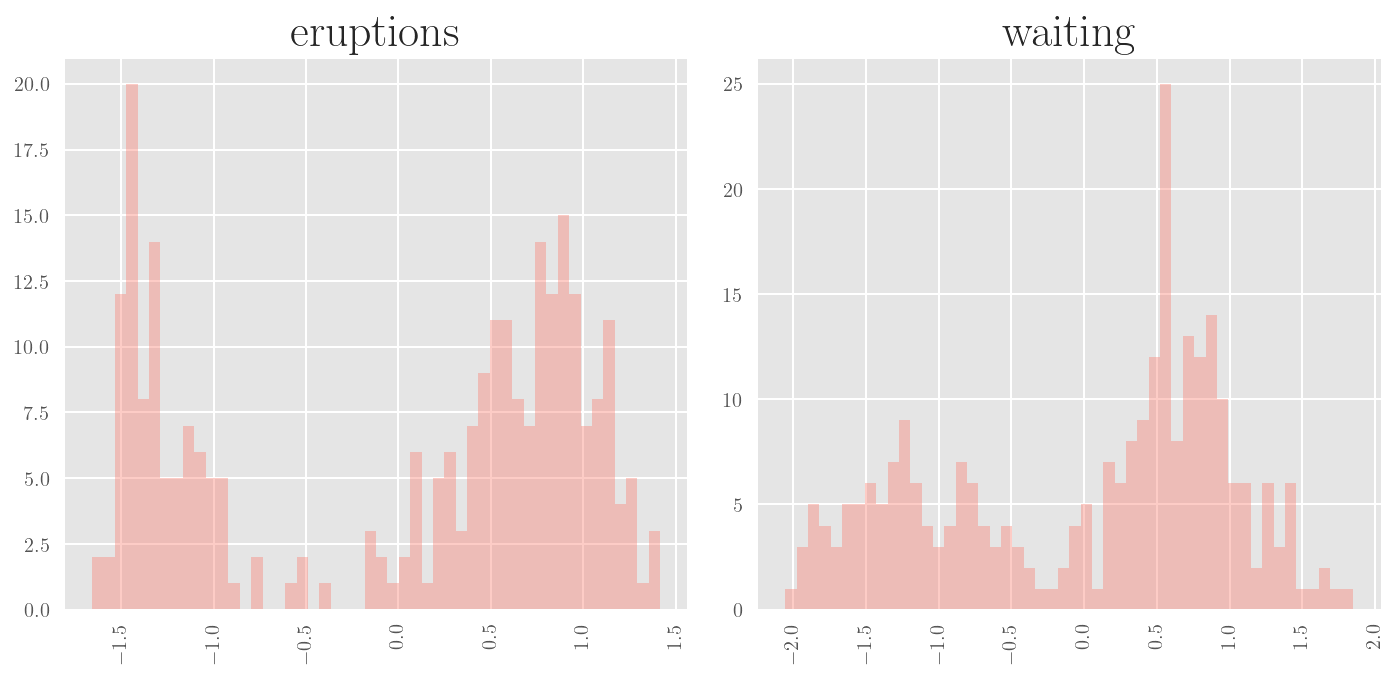

In [8]:
data.hist(bins=50, alpha = 0.4, color='salmon', xrot=90, figsize=(10,5));
plt.tight_layout()

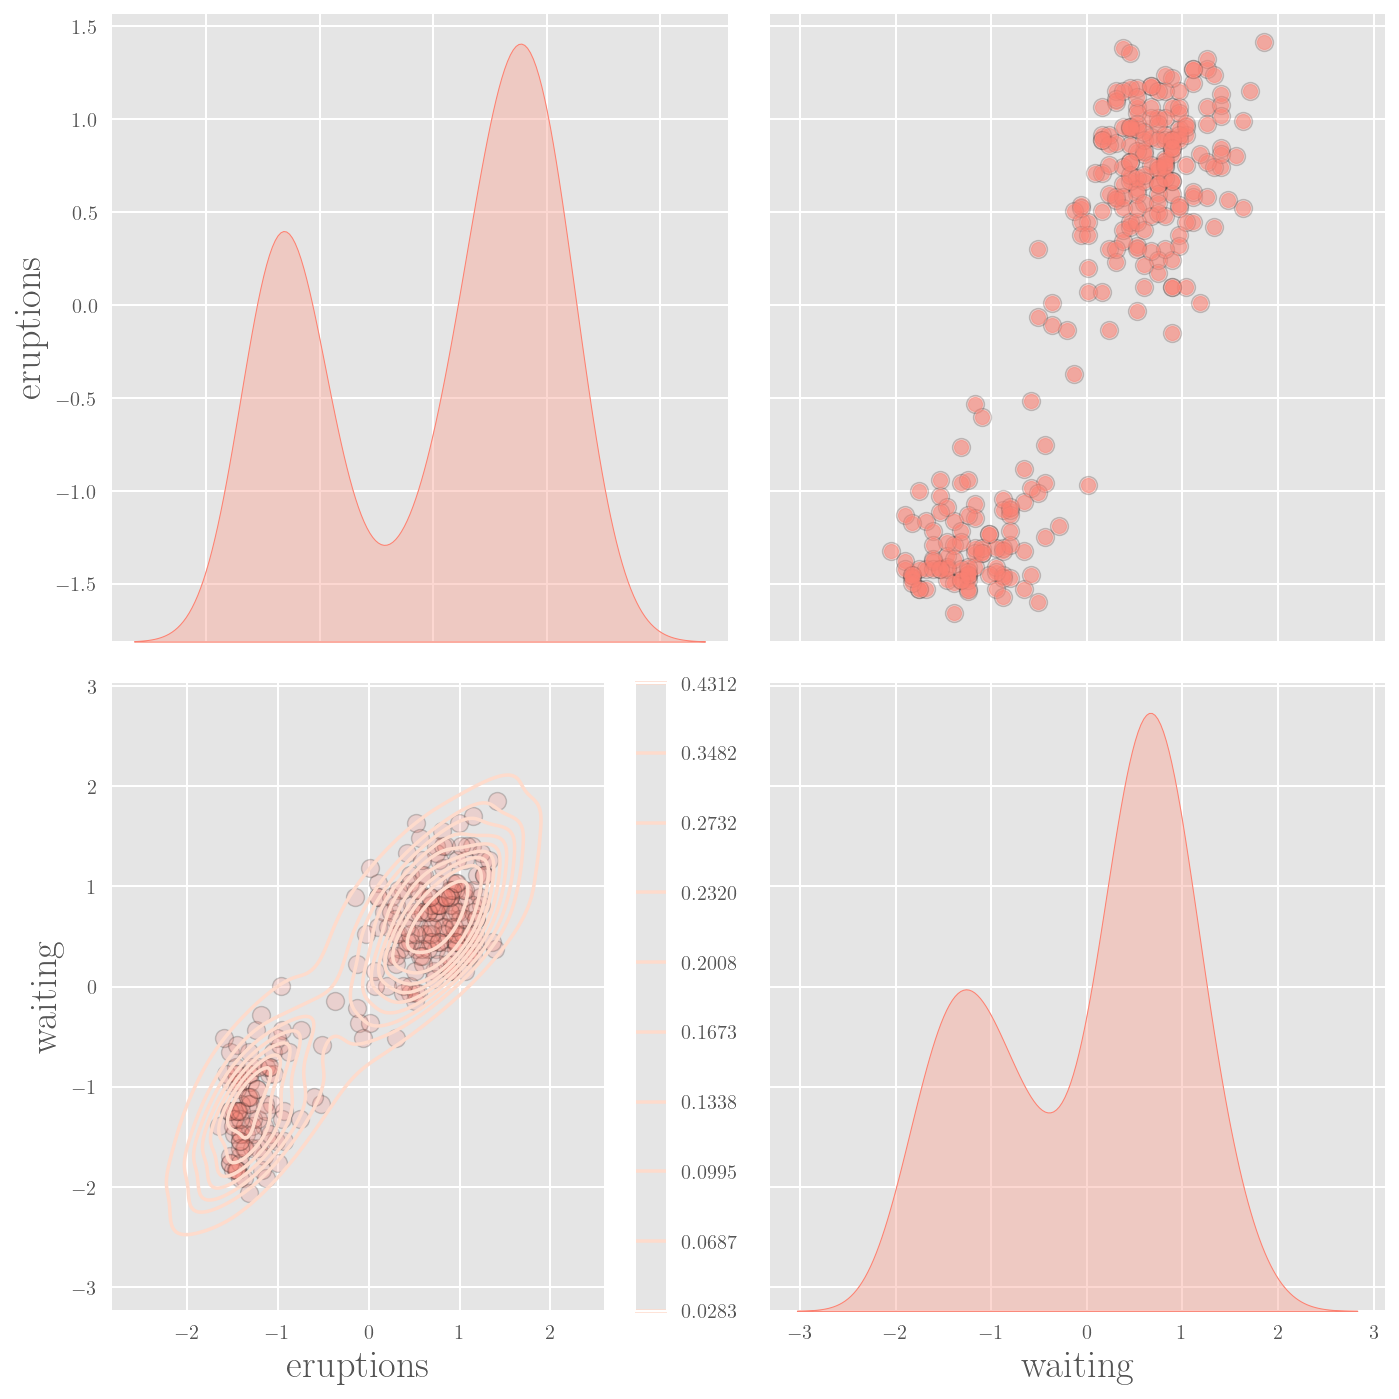

In [9]:

sns.set_palette("Reds")
sample = data
g = sns.pairplot(sample, diag_kind='kde', 
                   plot_kws = { 'alpha': 0.20, 's': 80, 'edgecolor': 'k', 'color':'salmon'}, 
                   size=5, );
g.map_diag(sns.kdeplot, color='salmon',  shade=True);
g.map_upper(plt.scatter, color='salmon', alpha=0.5);
g.map_lower(sns.kdeplot, shade=False, shade_lowest=False, cbar=True);
plt.tight_layout()

# Regression

It looks like a simple linear regression model is unlikely to work,but still lets baseline it. 

In [10]:
X, y = data[['eruptions']], data['waiting']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,train_size=0.5)

## Build a linear regression model



In [12]:
model = LinearRegression();
model.fit(X_train, y_train);

Recall that a linear regression model is given by the equation:

\begin{equation} y =  \beta_0 + \beta_1 x + \epsilon\end{equation}

where:
$\epsilon$ is the irreducible error term, so that the model is essentially:

\begin{equation} \hat{y} =  \beta_0 + \beta_1 x \end{equation}

What values of $\beta_0$ (the intercept) and $\beta_1$ (the slope) is this model predicting? We can inspect this as follows:

In [13]:
print (f'Intercept: {model.intercept_}, Slope: {model.coef_}')

Intercept: -0.011977424922084284, Slope: [0.91685839]


## Predictions from the model

let the model make predictions on the **test** data, something the model has not seen so far. By comparing the predictions to the actual values, will get a sense of how well the model has learned to generalize from the data. 


In [14]:
yhat = model.predict(X_test)
print("Root Mean Squared Error: %.2f"
      % mean_squared_error(y_test, yhat, squared=False))
r2 = r2_score(y_test, yhat)
print(rf"Coefficient of Determination (R^2):{r2}")

Root Mean Squared Error: 0.45
Coefficient of Determination (R^2):0.7617235091913751


The coefficient of determination, $R^2$ indicates a fairly good model. The root mean squared error of 6-minutes is quite good, given the average waiting time of about 71 minutes.  Let's continue on to the residual analysis.

## Residual Analysis

We will start by plotting the residuals from the predictions. the residual from the prediction $\hat{y}_i$ on a particular datum $(x_i, y_i)$ is defined as: 

\begin{equation}\mathbf{ r_i = \hat{y}_i  - y_i }\end{equation}

We will use the `yellowbrick` library for looking at the model characteristics.

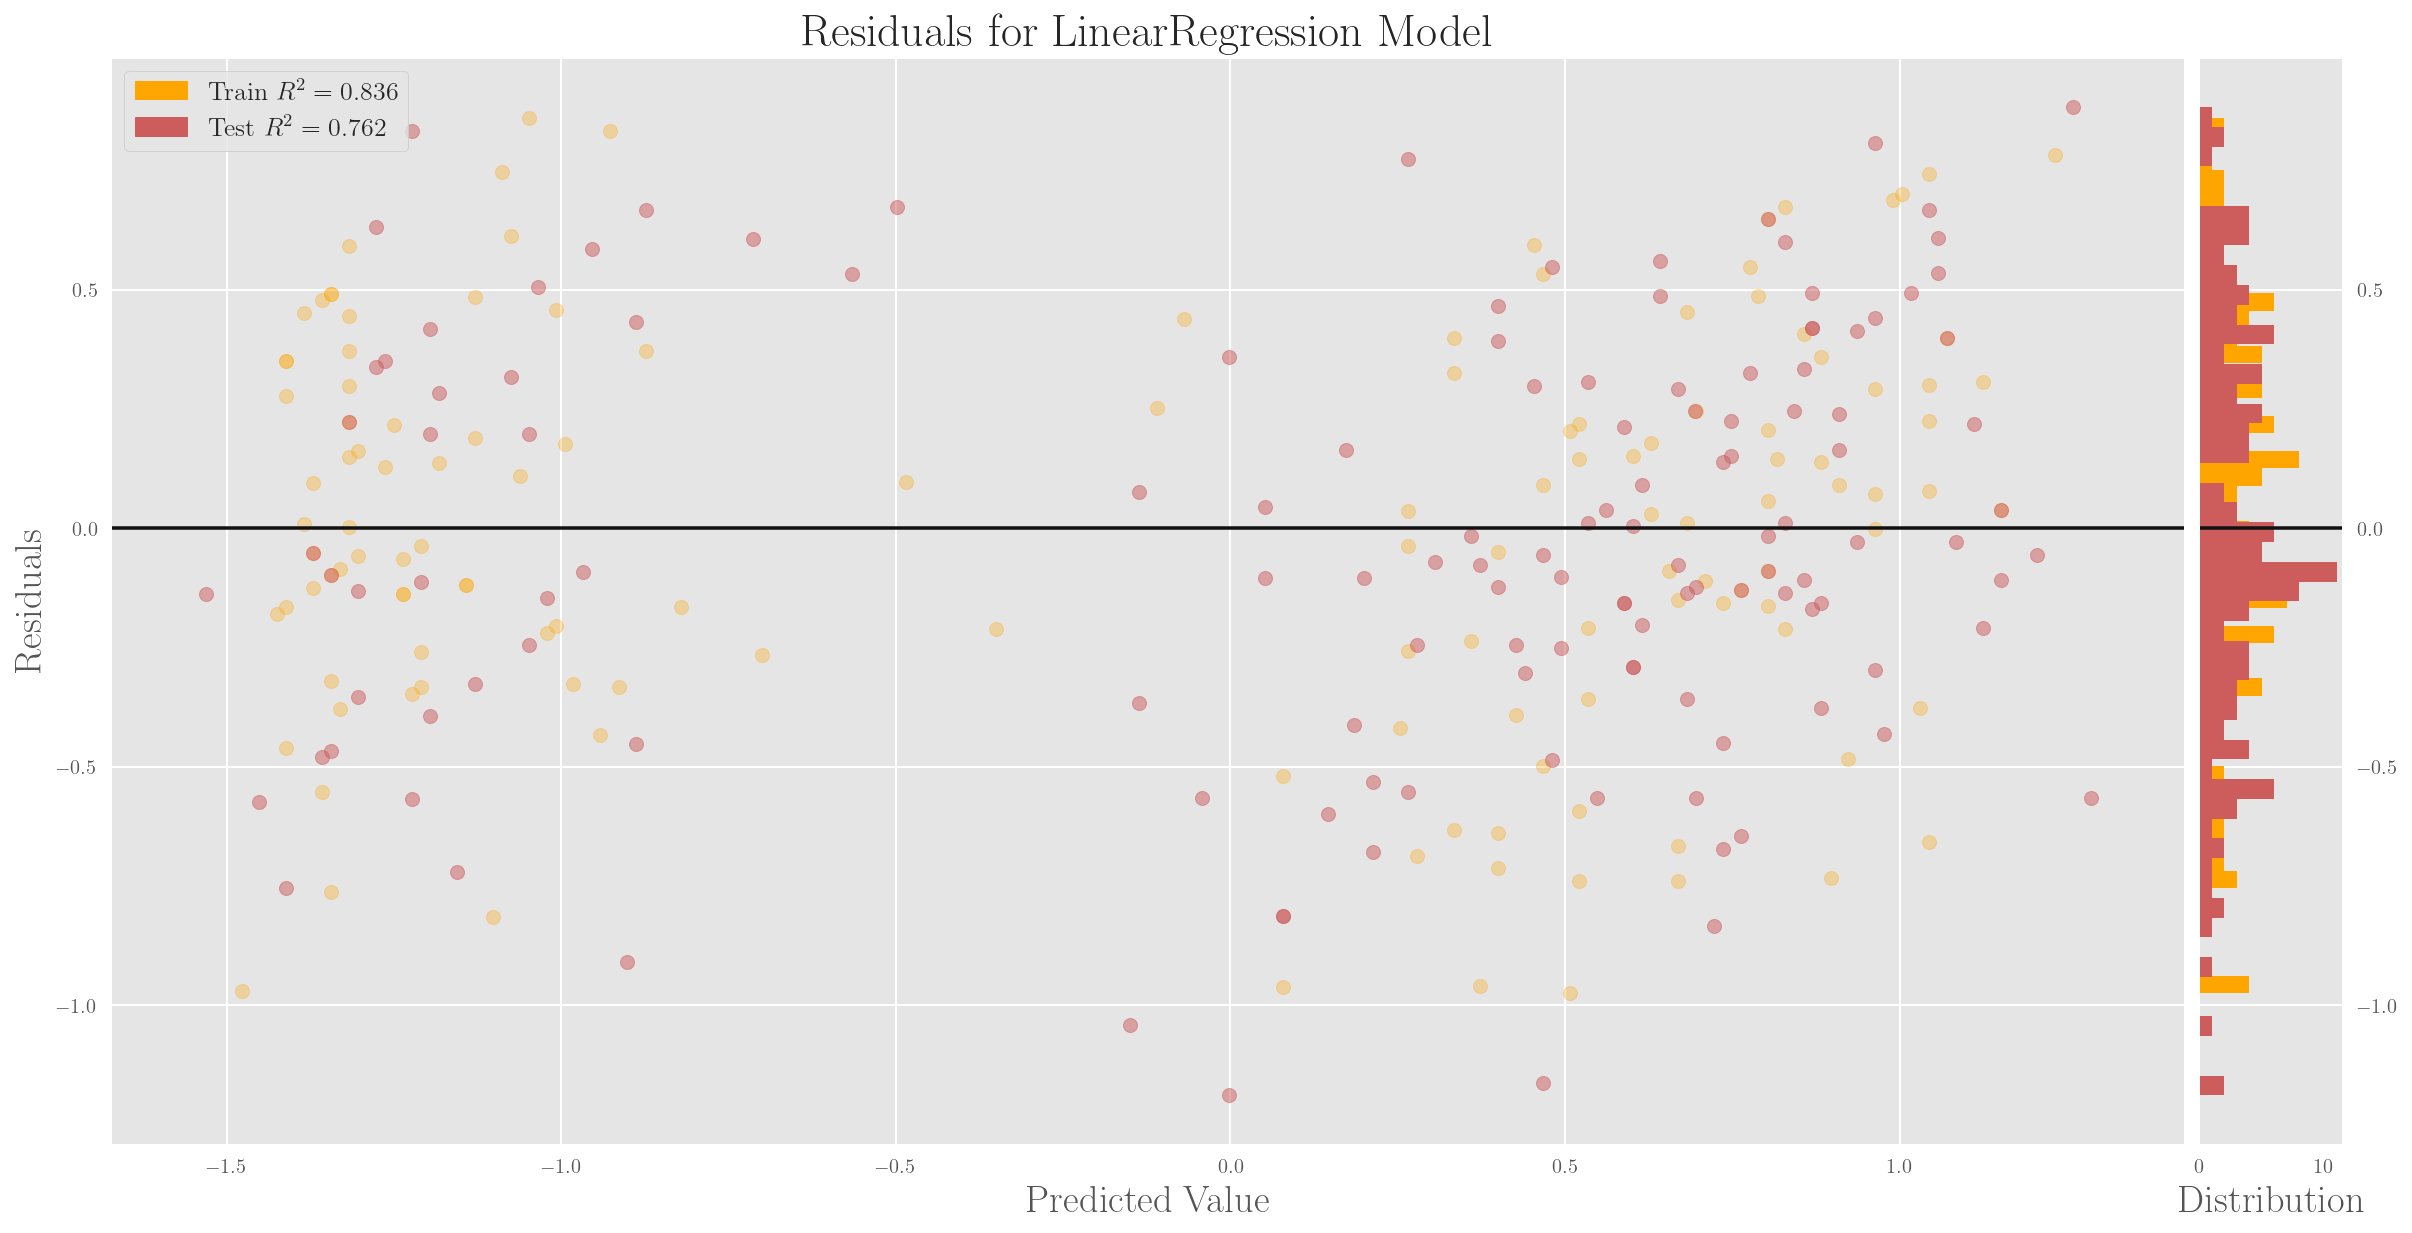

In [15]:
from yellowbrick.regressor import residuals_plot
viz = residuals_plot(model, X_train, y_train, X_test, y_test, 
                     train_color='orange', test_color='IndianRed', train_alpha=0.3, test_alpha=0.5)

The residuals do not display any pronounced pattern, and have a rough homoscedasticity. 

## Visualization of the model predictions

let us visualize the predictions of the model, and superimpose it on the actual data. 

In [16]:
 
XX = pd.DataFrame(data={'x': np.linspace(data['eruptions'].min(), data['eruptions'].max(), 1000)}) 
yhat = model.predict(XX).reshape(-1,1)


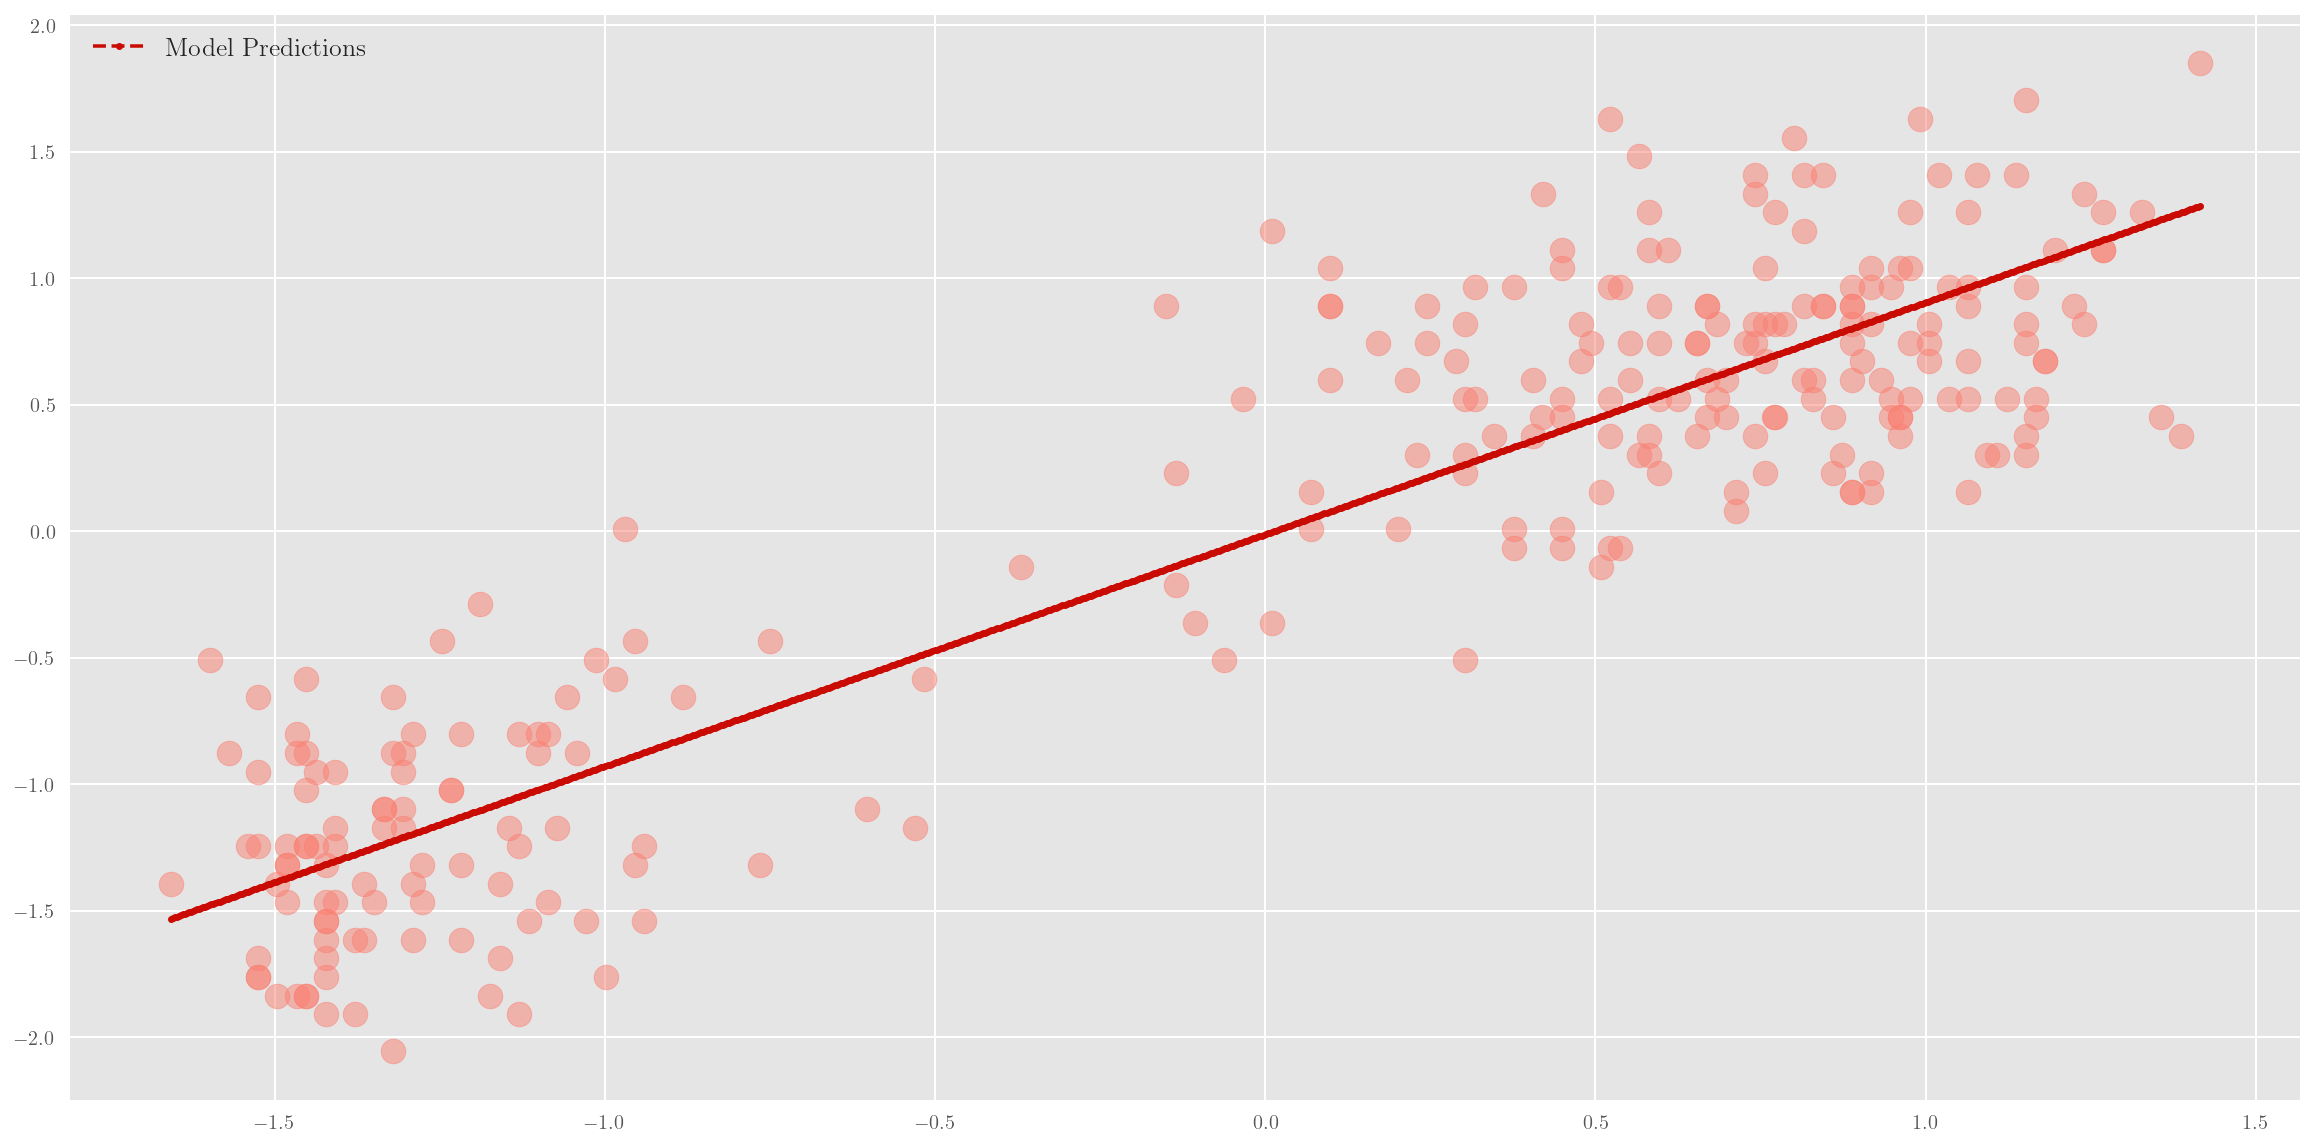

In [17]:
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(data['eruptions'], data['waiting'], alpha=0.5, s=150, color='salmon')
ax.plot(XX.x, yhat, 'r--.', label="Model Predictions")
ax.legend(loc='best');

This simple linear model seems to have proved quite an effective estimator to predict waiting time for the next eruption.

*Would polynomial regression provide a better model? explain the results?* 